In [67]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import sklearn.metrics

import time
import tqdm
import torch

from torch.utils.data import DataLoader

%run models/models.ipynb

plt.style.use('dark_background')

### Datasets

In [68]:
class AssetDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, chunk_size, dataset_size, scheme=None, normalize=False):
        
        # Scheme
        
        default_scheme = {'initial_asset_price': 
                              {'binary': True,
                               'encoding_format': '>f', 
                               'bits_count': 32,
                               'factor': 1,
                               'target_column': False},
                          'volatility': 
                              {'binary': True,
                               'encoding_format': 'i1', 
                               'bits_count': 8,
                               'factor': 100,
                               'target_column': False},
                          'asset_price':
                              {'binary': True,
                               'encoding_format': '>f', 
                               'bits_count': 32,
                               'factor': 1,
                               'target_column': False},
                          'probability':
                              {'binary': False,
                               'factor': 1,
                               'target_column': True}}                       
        
        self.scheme = scheme or default_scheme
                   
        target_column, target_parameters = next((column, parameters)
                                                for column, parameters in self.scheme.items()
                                                if parameters['target_column'])        
           
        # Parameters
        
        fields_count = 0
        data_dtype = 'i1'

        target_flags = []
        
        for column, parameters in self.scheme.items():
            
            if parameters['binary']:                 
                column_size = parameters['bits_count']
                
            else:
                data_dtype = float
                column_size = 1
            
            fields_count += column_size
            
            target_flags_for_column = [parameters['target_column']] * column_size
            
            target_flags.extend(target_flags_for_column)
            
        self.target_flags_vector = np.array(target_flags)
        
        
        # Data

        chunks_count = dataset_size // chunk_size
        
        self.data = np.zeros(shape=(dataset_size, fields_count), dtype=data_dtype)
        self.not_encoded_data = np.zeros(shape=(dataset_size, len(self.scheme)), dtype=data_dtype)
        
        dataset_iterator = pd.read_csv(dataset_path, iterator=True, chunksize=chunk_size)
        
        chunk_tracker = tqdm.tqdm(range(chunks_count),
                                  desc=f"Loading",
                                  ncols=110,
                                  unit='chunk',
                                  total=chunks_count)                          
        # Loading
        
        row_offset = 0

        for chunk_index in chunk_tracker:
            
            chunk = next(dataset_iterator)

            column_offset = 0
            not_encoded_column_offset = 0

            for column_name, parameters in self.scheme.items():
                
                factor = parameters.get('factor', 1)
                
                conversion_function = parameters.get('conversion', lambda x: x)
                
                column_chunk = chunk[column_name]             
                
                if normalize:
                
                    column_chunk = column_chunk - column_chunk.mean()
                    
                    column_chunk = column_chunk / np.abs(column_chunk).max()
                    
                column_chunk = conversion_function(column_chunk * factor) 
                
                if parameters['binary']:
                    column = self.encode_to_bits(column_chunk,
                                                 dtype=parameters['encoding_format'], 
                                                 bits_count=parameters['bits_count']) 
                    
                    column_size = parameters['bits_count']
                    
                else:                        
                    column = column_chunk.to_numpy().reshape(-1, 1)                        
                    column_size = 1             

                self.data[row_offset : row_offset + chunk_size, 
                          column_offset : column_offset + column_size] = column
                
                self.not_encoded_data[row_offset : 
                                      row_offset + chunk_size, 
                                      not_encoded_column_offset : 
                                      not_encoded_column_offset + 1] = column_chunk.to_numpy().reshape(-1, 1)                

                column_offset += column_size
                
                not_encoded_column_offset += 1

            row_offset += chunk_size
                
        self.fields = self.data[:, ~self.target_flags_vector].astype(int)
        self.targets = self.data[:, self.target_flags_vector]
        
        self.field_dimensions = np.max(self.fields, axis=0).astype(int) + 1
        
        self.field_dimensions[self.field_dimensions < 2] = 2
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index].squeeze()
        
        return fields, target
    

    def encode_to_bits(self, inputs, dtype='>f', bits_count=32):
    
        input_bytes = np.array([inputs], dtype=dtype)

        integer_view = input_bytes.view('uint8')

        bits_vector = np.unpackbits(integer_view)
        
        bits = bits_vector.reshape(-1, bits_count)
        
        return bits
    

    def decode_from_bits(self, bits, dtype='>f', bitorder='big'):        

        bits_vector = bits.reshape(-1)

        integer_view = np.packbits(bits_vector, bitorder=bitorder)

        output = integer_view.view(dtype)

        return output

### Splitter

In [69]:
class SequentialValueSampler(torch.utils.data.Sampler):

    def __init__(self, values):
        self.values = values

    def __iter__(self):
        return iter(self.values)

    def __len__(self):
        return len(self.values)


class Splitter:
    
    def __init__(self, dataset, shuffle=True, 
                 train_rate=0.8, valid_rate=0.1, 
                 batch_size=2048, dataloader_workers_count=8):
        
        self.dataset = dataset
                    
        dataset_length = len(dataset)

        train_length = int(dataset_length * train_rate)
        valid_length = int(dataset_length * valid_rate)

        test_length = dataset_length - train_length - valid_length
        
        self.lengths = (train_length, valid_length, test_length)

        dataset_indices = np.arange(dataset_length, dtype=int)
        
        if shuffle:        
            np.random.shuffle(dataset_indices)
        
        index_ranges = np.split(dataset_indices, (train_length,
                                                  train_length + valid_length))     
            
        train_sampler, valid_sampler, test_sampler = map(SequentialValueSampler, index_ranges)

        self.train_data_loader = DataLoader(dataset,
                                            batch_size=batch_size,
                                            sampler=train_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.valid_data_loader = DataLoader(dataset,                                  
                                            batch_size=batch_size,
                                            sampler=valid_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.test_data_loader = DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=dataloader_workers_count)   

### Trainer

In [70]:
class Trainer:

    def __init__(self, splitter,
                 learning_rate=0.001, weight_decay=1e-6,
                 embedding_dimensions=16,
                 model=None, criterion=None, metric=None, optimizer=None,
                 device='cpu', batch_logging_interval=100):

        %run models/models.ipynb 
        
        criterion = criterion or torch.nn.MSELoss()   

        metric = metric or sklearn.metrics.r2_score
        
        field_dimensions = splitter.dataset.field_dimensions
        
        model = model or CustomFactorizationMachine(field_dimensions, 
                                                    embedding_dimensions=embedding_dimensions)

        optimizer = torch.optim.Adam(params=model.parameters(), 
                                     lr=learning_rate, 
                                     weight_decay=weight_decay)
        
        self.device = torch.device(device)
        
        self.model = model.to(device)
        self.criterion = criterion
        self.metric = metric
        self.optimizer = optimizer
        self.splitter = splitter
        
        self.batch_logging_interval = batch_logging_interval
        
        self.train_data_loader = self.splitter.train_data_loader
        self.valid_data_loader = self.splitter.valid_data_loader
        self.test_data_loader = self.splitter.test_data_loader
        
        self.epoch_scores = []
        
        # TODO: EarlyStopper
    
    
    def fit(self, epochs=10):
        
        epoch_offset = len(self.epoch_scores)
        
        batches_count = epochs * len(self.splitter.train_data_loader)       
        
        fit_batch_tracker = tqdm.trange(
            batches_count,
            unit=' batches',
            ncols=110,
            mininterval=1,
        ) 
        
        for epoch in range(epochs):
            
            current_epoch = epoch_offset + epoch + 1
            max_epochs = epoch_offset + epochs

            fit_batch_tracker.set_description(f"Epoch: {current_epoch}/{max_epochs}")     
            
            self.train(fit_batch_tracker)
            
            epoch_score, _ = self.test(self.valid_data_loader)
            
            self.epoch_scores.append(epoch_score)
            
            fit_batch_tracker.set_postfix(r2=f"{epoch_score:.02f}")
            
        total_score, total_predictions = self.test(self.test_data_loader)
        
        print(f"\nTest {self.metric.__name__}: {total_score:.05f}")
    
    
    def train(self, fit_batch_tracker):

        self.model.train()

        interval_loss = 0

        for batch, (fields, target) in enumerate(self.splitter.train_data_loader):
            
            predictions = self.model(fields)
            
            loss = self.criterion(predictions, target.float())
            
            self.model.zero_grad()

            loss.backward()

            self.optimizer.step()

            interval_loss += loss.item()

            if not (batch + 1) % self.batch_logging_interval:

                average_loss = interval_loss / self.batch_logging_interval

                # fit_batch_tracker.set_postfix(loss=f"{average_loss:1.05f}")
                
                fit_batch_tracker.update(self.batch_logging_interval)
                
                interval_loss = 0
                
                
    def test(self, data_loader):
        
        self.model.eval()
    
        targets = []
        predictions = []

        with torch.no_grad():

            for fields, target in data_loader:

                prediction = self.model(fields)

                targets.extend(target.tolist())
                predictions.extend(prediction.tolist())

        score = self.metric(targets, predictions)
        
        return score, predictions
    

    def predict(self, indices):   
        
        encoded_fields = self.splitter.dataset.fields[indices]
        targets = self.splitter.dataset.targets[indices]

        self.model.eval()

        with torch.no_grad():

            predictions = self.model(torch.tensor(encoded_fields))
        
        return targets, predictions

### 1) FM

In [71]:
# Load Data

# DATASET_PATH = 'simulated_prices/15_dataset.csv'

# DATASET_PATH = 'simulated_prices/alex_dataset.csv'

# DATASET_PATH = 'simulated_prices/multi_modal_dataset.csv'

# DATASET_PATH = 'simulated_prices/20_dataset.csv'

DATASET_PATH = 'simulated_prices/23_dataset.csv'


DATASET_SIZE = 50000 * 2
# DATASET_SIZE = 50000

ENCODE = True
# ENCODE = False

NORMALIZE = False


SCHEME = {
          'initial_asset_price': 
              {'binary': ENCODE,
               'encoding_format': 'uint8', 
               'bits_count': 8,
               'factor': 1,
               'target_column': False},
          'volatility': 
              {'binary': ENCODE,
               'encoding_format': 'uint8', 
               'bits_count': 8,
               'factor': 100,
               'target_column': False},
          'asset_price':
            {'binary': ENCODE,
             'encoding_format': 'uint8', 
             'bits_count': 8,
             'factor': 10,
             # 'conversion': lambda x: x * 100 + 3,
             # 'inversion': lambda x: (x - 3) / 100,
             'target_column': False},
          'probability':
              {'binary': False,
               'factor': 100000,              
               'target_column': True}
         }  

dataset = AssetDataset(
    DATASET_PATH, 
    chunk_size=DATASET_SIZE, 
    dataset_size=DATASET_SIZE,
    scheme=SCHEME,
    normalize=NORMALIZE
)

splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)


print("Dataset field:", dataset.fields.shape)
print("Dataset targets:", dataset.targets.shape) 
# print("dataset.field_dimensions:", dataset.field_dimensions)
print("Splitter lengths:", splitter.lengths) 

Loading: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10chunk/s]

Dataset field: (100000, 24)
Dataset targets: (100000, 1)
Splitter lengths: (80000, 10000, 10000)


In [72]:
trainer.fit(epochs=1)

Epoch: 1/1: 100%|███████████████████████████████████████████| 800/800 [00:02<00:00, 274.23 batches/s, r2=0.54]


Test r2_score: 0.54504


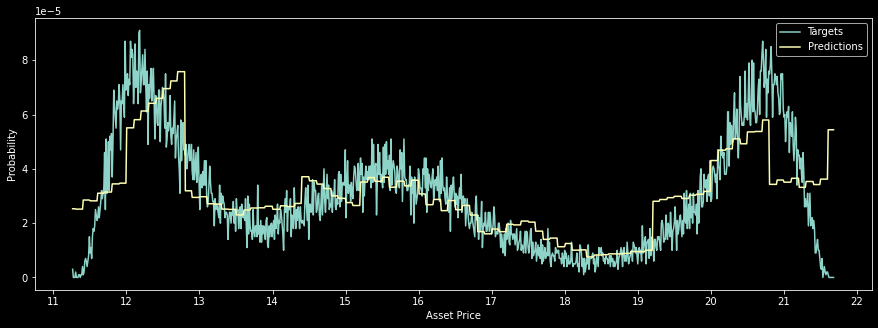

In [73]:
# Predict

indices = np.arange(0, len(dataset), 100)

targets, predictions = trainer.predict(indices)

probability_factor = dataset.scheme['probability']['factor']

defactored_targets = np.array(targets) / probability_factor
defactored_predictions = np.array(predictions) / probability_factor

asset_prices = dataset.not_encoded_data[indices, -2]
defactored_asset_prices = asset_prices / dataset.scheme['asset_price']['factor']


# Plot

figure = plt.gcf()
figure.set_size_inches(15, 5)

plt.plot(defactored_asset_prices, defactored_targets, label=f"Targets")
plt.plot(defactored_asset_prices, defactored_predictions, label=f"Predictions")

plt.locator_params(axis='x', nbins=20)

plt.xlabel("Asset Price")
plt.ylabel("Probability")
plt.legend()

plt.show()

### 2) QUBO

In [74]:
class Qubo:
    
    def __init__(self, inputs, trainer,
                 one_hot_scheme=None, maximize=True,
                 penalty_value=1000, ):
        
        default_one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
        self.one_hot_scheme = one_hot_scheme or default_one_hot_scheme 
        
        self.one_hot_decoding_scheme = {value: key for key, value in 
                                        self.one_hot_scheme.items()}
        
        # dimod.ExactSolver
        
        self.inputs = inputs        
        self.trainer = trainer
        self.maximize = maximize
        self.penalty_value = penalty_value
        
        
        # Load weights
        
        state_dict = trainer.model.state_dict()

        factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()
                     
        self.factorization_matrix = factorization_matrix
        
        self.input_penalty = self.get_input_penalty()
        
        self.one_hot_penalty = self.get_one_hot_penalty()
        
        self.qubo_coefficients = self.get_qubo_coefficients()
        
        # print(self.input_penalty)
        # print(self.one_hot_penalty)
        # print(self.qubo_coefficients)
        
        
    def get_input_penalty(self):

        encoded_values = dict()
        
        dataset = self.trainer.splitter.dataset

        for column, value in self.inputs.items():
            
            parameters = dataset.scheme[column]

            dtype = parameters['encoding_format']
            bits_count = parameters['bits_count']

            conversion = parameters.get('conversion', lambda x: x)
            factor = parameters.get('factor', 1)

            converted_value = conversion(factor * value)

            encoded_values[column] = dataset.encode_to_bits(inputs=converted_value, 
                                                            dtype=dtype, 
                                                            bits_count=bits_count)

        example_input = np.hstack(list(encoded_values.values()) or [[]]).squeeze()

        one_hot_fields = self.bits_to_one_hot(example_input)

        total_spins_count = len(self.factorization_matrix)

        fixed_spins_count = len(one_hot_fields)

        variable_spins_count = total_spins_count - fixed_spins_count


        input_penalty_vector = self.bit_to_spin(one_hot_fields) * -1 * self.penalty_value

        input_penalty_vector.resize(total_spins_count)

        input_penalty = np.diag(input_penalty_vector)
        
        self.fixed_spins_count = fixed_spins_count
        self.variable_spins_count = variable_spins_count

        # print("encoded_values:\n", encoded_values)
        # print("example_input:\n", example_input)
        # print("one_hot_fields:\n", one_hot_fields)
        # print("spin counts:\n", (fixed_spins_count, variable_spins_count, total_spins_count))
        # print("input_penalty_vector:\n", input_penalty_vector)
        # print("input_penalty:\n", input_penalty.shape)
        
        return input_penalty
    

    def get_one_hot_penalty(self):

        one_hot_pair_penalty = self.penalty_value * np.array([[-1,  2],
                                                              [ 2, -1]])

        one_hot_penalty_diagonal = np.concatenate((np.zeros(self.fixed_spins_count // 2),
                                                   np.ones(self.variable_spins_count // 2)))

        one_hot_penalty_matrix = np.diag(one_hot_penalty_diagonal)

        one_hot_penalty = np.kron(one_hot_penalty_matrix, one_hot_pair_penalty)


#         print("one_hot_pair_penalty:\n", one_hot_pair_penalty)
#         print("one_hot_penalty_diagonal:\n", one_hot_penalty_diagonal)
#         # print("one_hot_penalty_matrix:\n", one_hot_penalty_matrix)
#         print("one_hot_penalty:\n", one_hot_penalty.shape)
        
        return one_hot_penalty
    
    
    def get_qubo_coefficients(self):

        coupling_matrix = self.factorization_matrix @ self.factorization_matrix.T

        if self.maximize:

            coupling_matrix = -coupling_matrix

        penalty_matrix = self.input_penalty + self.one_hot_penalty

        penalized_coupling_matrix = coupling_matrix + penalty_matrix

        qubo_coefficients = self.get_coupling_coefficients(penalized_coupling_matrix)
        
        self.coupling_matrix = coupling_matrix
        
        self.penalized_coupling_matrix = penalized_coupling_matrix


#         print("self.factorization_matrix:\n", self.factorization_matrix.shape)
#         print("coupling_matrix:\n", coupling_matrix.shape)
#         print("penalized_coupling_matrix part:\n", penalized_coupling_matrix[-3:, -3:])
#         print("qubo_coefficients part:\n", qubo_coefficients.__repr__()[-60:])
        
        return qubo_coefficients



    def bits_to_one_hot(self, bits):
        
        one_hot_bits = [self.one_hot_scheme[bit] for bit in bits]

        one_hot_array = np.array(one_hot_bits, dtype='i1').ravel()

        return one_hot_array
    
    
    def one_hot_to_bits(self, one_hot):    

        bits = []

        for one_hot_pair in one_hot.reshape(-1, 2):

            bit = self.one_hot_decoding_scheme[tuple(one_hot_pair)]

            bits.append(bit)

        bits_array = np.array(bits, dtype='i1')    

        return bits_array
    
    
    def bit_to_spin(self, binary):    
        return binary * 2 - 1

    def spin_to_bit(self, spin):    
        return (spin + 1) // 2
    
    
    def get_coupling_coefficients(self, coupling_matrix):

        coupling_coefficients = dict()

        for row_index, row in enumerate(coupling_matrix):

            for column_index, cell in enumerate(row[row_index:], row_index):

                coupling_coefficients[row_index, column_index] = cell

        return coupling_coefficients
    
    
    def is_correct_one_hot(self, record):

        sample = record.sample

        fields_spins = np.array(list(sample.values()))

        fields_one_hot = self.spin_to_bit(fields_spins)

        for one_hot_pair in fields_one_hot.reshape(-1, 2):

            one_hot_tuple = tuple(one_hot_pair)

            if one_hot_tuple not in self.one_hot_scheme.values():            

                return False

        return True
    
    
    def decode_sample(self, sample):
        
        spins = np.array(list(sample.values()))

        one_hot = qubo.spin_to_bit(spins)

        bits = qubo.one_hot_to_bits(one_hot)


        offset = 0
        results = dict()

        for column, parameters in dataset.scheme.items():

            if parameters['target_column']:
                continue

            bits_count = parameters['bits_count']
            
            factor = dataset.scheme[column].get('factor', 1)
            
            inversion = dataset.scheme[column].get('inversion', lambda x: x)
            

            column_bits = bits[offset : offset + bits_count]

            decoded_value = dataset.decode_from_bits(column_bits,
                                                     dtype=parameters['encoding_format'])

            value = inversion(decoded_value) / factor  

            results[column] = value.item()

            offset += bits_count

        
        return results

In [75]:
# 1) Example inputs

INPUTS = {
    'initial_asset_price': 15,
    'volatility': 0.1
}

PENALTY_VALUE = 1000

MAXIMIZE = True

qubo = Qubo(trainer=trainer,
            inputs=INPUTS,
            penalty_value=PENALTY_VALUE,
            maximize=MAXIMIZE)

### 5) QUBO Energies

In [76]:
# Range penalty

encoded_asset_prices = dataset.fields[:, 16:]


def get_range_penalty(encoded_asset_prices, penalty_value):

    one_hot_asset_prices = np.array([qubo.bits_to_one_hot(price) for price in encoded_asset_prices])

    asset_price_spins = qubo.bit_to_spin(one_hot_asset_prices)

    asset_price_spin_sums = asset_price_spins.sum(axis=0)

    range_penalties = asset_price_spin_sums * penalty_value

    range_penalty_vector = np.concatenate((np.zeros(32), range_penalties))

    range_penalty = np.diag(range_penalty_vector)

    range_qubo_coefficients = qubo.get_coupling_coefficients(qubo.penalized_coupling_matrix + range_penalty)
    
    print(range_penalty_vector, range_penalty_vector.shape, sum(range_penalty_vector))

    return range_penalty


# range_penalty = get_range_penalty(encoded_asset_prices, -0.1)
range_penalty = get_range_penalty(encoded_asset_prices, 100)

range_qubo_coefficients = qubo.get_coupling_coefficients(qubo.penalized_coupling_matrix + 
                                                         range_penalty) 

[       0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.  7052400. -7052400. -2276800.
  2276800.  -914000.   914000.   792400.  -792400.  -620600.   620600.
   -25200.    25200.   -25000.    25000.   -25000.    25000.] (48,) 0.0


In [91]:
# Excluded penalty

DTYPE = 'uint8'
BITS_COUNT = 8

# DTYPE = 'uint16'
# BITS_COUNT = 16


asset_prices = dataset.not_encoded_data[:, -2].astype(int)

all_asset_prices = np.arange(np.iinfo(DTYPE).max)

is_in_dataset = np.isin(all_asset_prices, asset_prices)

excluded_prices = all_asset_prices[~is_in_dataset]

encoded_excluded_prices = dataset.encode_to_bits(excluded_prices, dtype=DTYPE, bits_count=BITS_COUNT)


excluded_prices_penalty = get_range_penalty(encoded_excluded_prices, 1000)

excluded_qubo_coefficients = qubo.get_coupling_coefficients(
    qubo.penalized_coupling_matrix +
    excluded_prices_penalty 
)

[     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0. -74000.  74000.  22000. -22000.
   8000.  -8000. -10000.  10000.   6000.  -6000.      0.      0.      0.
      0.      0.      0.] (48,) 0.0


In [92]:
import dimod


indices = np.arange(0, len(dataset), 100)

PENALIZED = True


bqm = dimod.BinaryQuadraticModel.from_qubo(qubo.qubo_coefficients)

quadratic = bqm.quadratic
linear = bqm.linear
offset = bqm.offset

energies = []
bqm_energies = []

for row_bits in dataset.fields[indices]:  
    
    one_hot_row = qubo.bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))
    
    if PENALIZED:
        
        qubo_coefficients = qubo.qubo_coefficients
        
        # qubo_coefficients = range_qubo_coefficients
        
        # qubo_coefficients = excluded_qubo_coefficients
        
    else:

        qubo_coefficients = qubo.get_coupling_coefficients(qubo.coupling_matrix) 

    energy = dimod.utilities.qubo_energy(sample=sample, Q=qubo_coefficients)
        
    bqm_energy = dimod.utilities.ising_energy(sample=sample, J=quadratic, h=linear, offset=offset)
    
    energies.append(energy)
    bqm_energies.append(bqm_energy)    
    
# print("energies:\n", energies)
# print("bqm_energies:\n", bqm_energies)

In [93]:
# Predict

targets, predictions = trainer.predict(indices)

probability_factor = dataset.scheme['probability']['factor']

defactored_targets = np.array(targets) / probability_factor
defactored_predictions = np.array(predictions) / probability_factor

asset_prices = dataset.not_encoded_data[indices, -2]
defactored_asset_prices = asset_prices / dataset.scheme['asset_price']['factor']

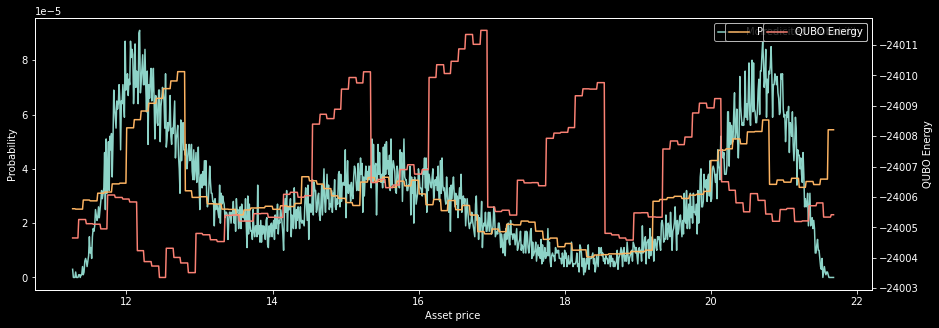

In [94]:
# Plot on 1 graph

figure, targets_ax = plt.subplots()

figure.set_size_inches(15, 5)

targets_ax.plot(defactored_asset_prices, defactored_targets, label="Monte-Carlo Probability")

targets_ax.set_xlabel("Asset price")
targets_ax.set_ylabel("Probability")
targets_ax.legend()

prediction_ax = targets_ax.twiny()

prediction_ax.get_xaxis().set_visible(False)

prediction_ax.plot(defactored_asset_prices, defactored_predictions, label="Predicited Probability", color='#fdb462')

prediction_ax.set_xlabel("Asset price")
prediction_ax.set_ylabel("Predicited Probability")
prediction_ax.legend()

qubo_ax = prediction_ax.twinx()

reversed_asset_prices = defactored_asset_prices[::-1]

# qubo_ax.plot(defactored_asset_prices, energies, label="QUBO Energy", color='#fa8174')
qubo_ax.plot(reversed_asset_prices, energies, label="QUBO Energy", color='#fa8174')

# qubo_ax.plot(reversed_asset_prices, bqm_energies, label="BQM Energy", color='r')

qubo_ax.invert_yaxis()

qubo_ax.set_xlabel("Asset price")
qubo_ax.set_ylabel("QUBO Energy")
qubo_ax.legend()

plt.show()

In [90]:
# # Plot on different graphs

# plt.figure(figsize=(15, 5))
# plt.plot(defactored_asset_prices, defactored_targets, label="Monte-Carlo Probability")

# plt.xlabel("Asset price")
# plt.ylabel("Monte-Carlo Probability")
# plt.legend()
# plt.show()

# plt.figure(figsize=(15, 5))
# plt.plot(defactored_asset_prices, defactored_predictions, label="Predicited Probability", color='#fdb462')

# plt.xlabel("Asset price")
# plt.ylabel("Predicited Probability")
# plt.legend()
# plt.show()

# plt.figure(figsize=(15, 5))
# plt.plot(defactored_asset_prices, energies, label="QUBO Energy", color='#fa8174')

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

# plt.xlabel("Asset price")
# plt.ylabel("QUBO Energy")
# plt.legend()
# plt.show()

# figure = plt.gcf()
# figure.set_size_inches(15, 5)

# plt.plot(defactored_asset_prices, bqm_energies, label="BQM Energy")

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

# plt.xlabel("Asset price")
# plt.ylabel("BQM Energy")
# plt.legend()
# plt.show()

### 3) Run on Simulator

In [82]:
from neal.sampler import SimulatedAnnealingSampler

import dimod

dimod.serialization.format.set_printoptions(width=110, depth=10)


shots_count = 10000

sampler = SimulatedAnnealingSampler()

# new_bqm = dimod.BinaryQuadraticModel(bqm.linear,
#                                      bqm.quadratic,
#                                      bqm.offset,
#                                      vartype=dimod.BINARY)

# spin_bqm = new_bqm.change_vartype(dimod.SPIN, inplace=False)


sampling_results = sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=shots_count)

# sampling_results = sampler.sample_qubo(Q=range_qubo_coefficients, num_reads=shots_count)

# sampling_results = sampler.sample_qubo(Q=excluded_qubo_coefficients, num_reads=shots_count)


# sampling_results = sampler.sample_ising(J=bqm.quadratic, h=bqm.linear, num_reads=shots_count)

# new_linear = {k[0]: v for k, v in qubo.qubo_coefficients.items() if k[0] == k[1]}

# sampling_results = sampler.sample_ising(J=qubo.qubo_coefficients, h=new_linear, num_reads=shots_count)

# sampling_results = sampler.sample(bqm=spin_bqm, num_reads=shots_count)

In [83]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

# print("sampling_results:\n", sampling_results)
# print("aggregated_results:\n", aggregated_results)
# print("filtered_results:\n", filtered_results)

sampling_results: 10000
aggregated_results: 256
filtered_results: 256


In [84]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = qubo.decode_sample(sample.sample)
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

filtered_columns = ['asset_price', 'energy', 'num_occurrences']

print("maximize:\n", MAXIMIZE)
print("inputs:\n", INPUTS)
print("decoded_results:\n", decoded_results.head())

maximize:
 True
inputs:
 {'initial_asset_price': 15, 'volatility': 0.1}
decoded_results:
    initial_asset_price  volatility  asset_price        energy  num_occurrences
0                 15.0         0.1         16.0 -24011.478175               32
1                 15.0         0.1         16.2 -24011.342888               35
2                 15.0         0.1         16.1 -24011.019286               43
3                 15.0         0.1         16.3 -24010.868335               44
4                 15.0         0.1         16.4 -24010.460895               44


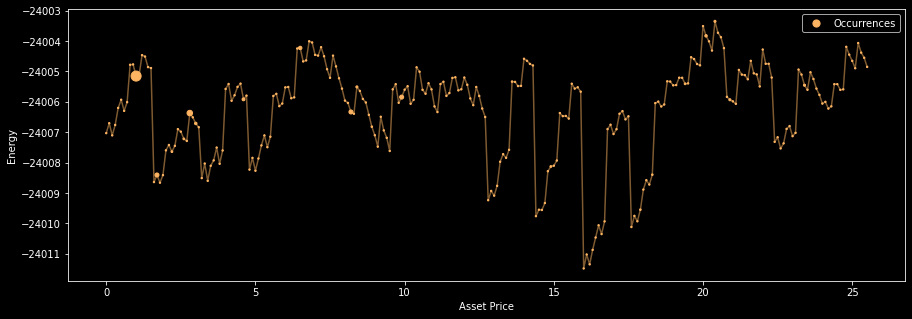

In [85]:
# Plot

results_by_asset_price = decoded_results.sort_values('asset_price')

energies = results_by_asset_price['energy'].to_numpy()
asset_prices = results_by_asset_price['asset_price'].to_numpy()

sizes = results_by_asset_price['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1


plt.plot(asset_prices, energies, color='#fdb462', alpha=0.5)

plt.scatter(asset_prices, energies,
            label=f"Occurrences",
            color='#fdb462',
            s=sizes + 1)

plt.xlabel("Asset Price")
plt.ylabel("Energy")
plt.legend()

figure = plt.gcf()
figure.set_size_inches(15, 5)

plt.show()

In [27]:
# 10 - 20

# Forbidden:
#
# 00000000 - 0
# ...
# 00001001 - 9

# 00001010
# 00010100

# Penalty mask:
# 00000000
#
# 0 -> -1000
# 1 -> 1000

# Penalty vector:
#
# [-1000, -1000, -1000, ..., -1000]



### 4) Run on DWave device

In [29]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 1

In [40]:
# D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")

# # D-Wave Advantage device
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

device.name: DW_2000Q_6
device.properties.provider.topology: {'type': 'chimera', 'shape': [16, 16, 4]}
device.properties.provider.qubitCount: 2048
len(device.properties.provider.couplers): 5974
device.properties.service.shotsRange: (1, 10000)
device.properties.service.deviceLocation: British Columbia, Canada


In [41]:
qubo.coupling_matrix.shape

(48, 48)

In [42]:
dwave_2000q_sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
embedded_sampler = EmbeddingComposite(dwave_2000q_sampler)

In [43]:
num_reads = 1000

# if cost_tracker.qpu_tasks_cost() < COST_LIMIT:

    # sampling_results = embedded_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=num_reads)

In [44]:
print("quantum_tasks_statistics:", cost_tracker.quantum_tasks_statistics())
print("qpu_tasks_cost:", cost_tracker.qpu_tasks_cost())
print("simulator_tasks_cost:", cost_tracker.simulator_tasks_cost())

quantum_tasks_statistics: {}
qpu_tasks_cost: 0
simulator_tasks_cost: 0


In [45]:
# # Save results

# RESULTS_FILENAME = 'results/2000q_48_qubits.npy'

# np.save(RESULTS_FILENAME, sampling_results)

In [50]:
# Load results

RESULTS_FILENAME = 'results/2000q_48_qubits.npy'

sampling_results = np.load(RESULTS_FILENAME, allow_pickle=True).item()

In [51]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

# print("sampling_results:\n", sampling_results)
# print("aggregated_results:\n", aggregated_results)
# print("filtered_results:\n", filtered_results)

sampling_results: 450
aggregated_results: 339
filtered_results: 164


In [52]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = qubo.decode_sample(sample.sample)
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

filtered_columns = ['asset_price', 'energy', 'num_occurrences']

pd.set_option('display.max_rows', 10)

print("maximize:\n", MAXIMIZE)
print("inputs:\n", INPUTS)
print("decoded_results:\n", decoded_results[:].head())

maximize:
 True
inputs:
 {'initial_asset_price': 15, 'volatility': 0.1}
decoded_results:
    initial_asset_price  volatility  asset_price        energy  num_occurrences
0                 15.0         0.1         22.4 -24018.975494                6
1                 15.0         0.1         22.5 -24018.357479                1
2                 15.0         0.1         22.8 -24017.982652               11
3                 15.0         0.1         22.7 -24017.740591                1
4                 15.0         0.1         22.9 -24017.389839                4


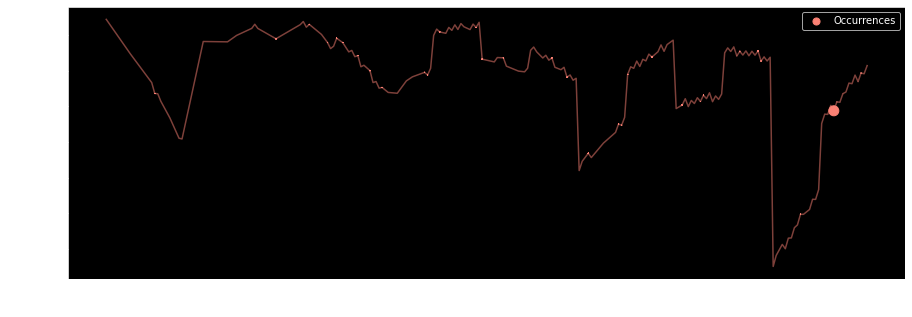

In [53]:
# Plot

results_by_asset_price = decoded_results.sort_values('asset_price')

energies = results_by_asset_price['energy'].to_numpy()
asset_prices = results_by_asset_price['asset_price'].to_numpy()

sizes = results_by_asset_price['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100


plt.plot(asset_prices, energies, color='#fa8174', alpha=0.5)

plt.scatter(asset_prices, energies,
            label=f"Occurrences",
            color='#fa8174',
            s=sizes)

plt.xlabel("Asset Price")
plt.ylabel("Energy")
plt.legend()

figure = plt.gcf()
figure.set_size_inches(15, 5)

plt.show()

### DWave 2000Q - Minimal Example

In [30]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

import dimod

In [31]:
from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 1

In [32]:
# D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")

# # D-Wave Advantage device
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

device.name: DW_2000Q_6
device.properties.provider.topology: {'type': 'chimera', 'shape': [16, 16, 4]}
device.properties.provider.qubitCount: 2048
len(device.properties.provider.couplers): 5974
device.properties.service.shotsRange: (1, 10000)
device.properties.service.deviceLocation: British Columbia, Canada


In [33]:
# Example model

num_reads = 100

vartype = dimod.SPIN
# vartype = dimod.BINARY

quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
linear = {0: +1.0}
offset = 0.0

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

In [34]:
sampler = dimod.SimulatedAnnealingSampler()

response = sampler.sample(model, num_reads=num_reads)

response_aggregate = response.aggregate()
print(response_aggregate)

   0  1  2  3  4 energy num_oc.
0 -1 -1 +1 -1 +1   -6.0     100
['SPIN', 1 rows, 100 samples, 5 variables]


In [35]:
# Real device

sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
embedded_sampler = EmbeddingComposite(sampler)

In [36]:
# if cost_tracker.qpu_tasks_cost() < COST_LIMIT:    

#     response = embedded_sampler.sample(model, num_reads=num_reads)

In [37]:
print(response)

    0  1  2  3  4 energy num_oc.
0  -1 -1 +1 -1 +1   -6.0       1
1  -1 -1 +1 -1 +1   -6.0       1
2  -1 -1 +1 -1 +1   -6.0       1
3  -1 -1 +1 -1 +1   -6.0       1
4  -1 -1 +1 -1 +1   -6.0       1
5  -1 -1 +1 -1 +1   -6.0       1
6  -1 -1 +1 -1 +1   -6.0       1
7  -1 -1 +1 -1 +1   -6.0       1
...
99 -1 -1 +1 -1 +1   -6.0       1
['SPIN', 100 rows, 100 samples, 5 variables]


In [38]:
print("quantum_tasks_statistics:", cost_tracker.quantum_tasks_statistics())
print("qpu_tasks_cost:", cost_tracker.qpu_tasks_cost())
print("simulator_tasks_cost:", cost_tracker.simulator_tasks_cost())

quantum_tasks_statistics: {}
qpu_tasks_cost: 0
simulator_tasks_cost: 0


### QUBO to BQM

In [127]:
import dimod


# Example model

num_reads = 100

vartype = dimod.SPIN
# vartype = dimod.BINARY

quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
# linear = {0: +1.0}
linear = {}
offset = 0.0

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

sampler = dimod.SimulatedAnnealingSampler()

# response = sampler.sample(model, num_reads=num_reads)

response = sampler.sample_ising(J=quadratic, h=linear, num_reads=num_reads)

print(response.aggregate())

   0  1  2  3  4 energy num_oc.
0 +1 +1 -1 +1 -1   -5.0      57
1 -1 -1 +1 -1 +1   -5.0      43
['SPIN', 2 rows, 100 samples, 5 variables]


In [128]:
new_qubo, offset = model.to_qubo()

new_qubo, offset

({(1, 0): 4.0,
  (4, 0): 8.0,
  (4, 1): 4.0,
  (2, 1): 4.0,
  (3, 4): 4.0,
  (3, 2): 4.0,
  (0, 0): -6.0,
  (1, 1): -6.0,
  (4, 4): -8.0,
  (2, 2): -4.0,
  (3, 3): -4.0},
 7.0)

In [136]:
new_qubo_with_offset = {key: value - offset for key, value in new_qubo.items()}

new_qubo_with_offset

{(1, 0): -3.0,
 (4, 0): 1.0,
 (4, 1): -3.0,
 (2, 1): -3.0,
 (3, 4): -3.0,
 (3, 2): -3.0,
 (0, 0): -13.0,
 (1, 1): -13.0,
 (4, 4): -15.0,
 (2, 2): -11.0,
 (3, 3): -11.0}

In [138]:
response = sampler.sample_qubo(Q=new_qubo, num_reads=num_reads)

print(response.aggregate())

   0  1  2  3  4 energy num_oc.
0  1  1  0  1  0  -12.0      54
1  0  0  1  0  1  -12.0      46
['BINARY', 2 rows, 100 samples, 5 variables]


In [131]:
new_model = dimod.BinaryQuadraticModel.from_qubo(new_qubo)

new_model

BinaryQuadraticModel({1: -6.0, 0: -6.0, 4: -8.0, 2: -4.0, 3: -4.0}, {(0, 1): 4.0, (4, 1): 4.0, (4, 0): 8.0, (2, 1): 4.0, (3, 4): 4.0, (3, 2): 4.0}, 0.0, 'BINARY')

In [133]:
response = sampler.sample(new_model, num_reads=num_reads)

print(response.aggregate())

   0  1  2  3  4 energy num_oc.
0  0  0  1  0  1  -12.0      52
1  1  1  0  1  0  -12.0      48
['BINARY', 2 rows, 100 samples, 5 variables]


### Save and load model

In [85]:
# import dill

# MODEL_PATH = 'saved_models/15_model.pt'

# model_parameters = {'state_dict': trainer.model.state_dict(),
#                     'scheme': trainer.splitter.dataset.scheme}

# # torch.save(model_parameters, MODEL_PATH, pickle_module=dill)

# # trainer.model.state_dict()

In [86]:
# loaded_trainer = Trainer(splitter=splitter, embedding_dimensions=16)

# model_parameters = torch.load(MODEL_PATH, pickle_module=dill)

# loaded_trainer.model.load_state_dict(model_parameters['state_dict'])

# loaded_scheme = model_parameters['scheme']

# loaded_trainer.model.eval()

In [87]:
# # Predict

# indices = np.arange(0, len(dataset), 1)

# targets, predictions = loaded_trainer.predict(indices)

# probability_factor = dataset.scheme['probability']['factor']

# defactored_targets = np.array(targets) / probability_factor
# defactored_predictions = np.array(predictions) / probability_factor

# # Plot

# figure = plt.gcf()
# figure.set_size_inches(15, 5)

# asset_prices = dataset.not_encoded_data[indices, 2]

# plt.plot(asset_prices, defactored_targets, label=f"Targets")
# plt.plot(asset_prices, defactored_predictions, label=f"Predictions")

# plt.locator_params(axis='x', nbins=20)

# plt.xlabel("Asset Price")
# plt.ylabel("Probability")
# plt.legend()

# plt.show()

In [68]:
# # Swap horizontal pairs

# a = np.outer(np.full(8, 10) ** np.arange(8),
#              range(1, 9))

# b_shape = a.shape * np.array([0.5, 2])

# b = a.reshape(b_shape.astype(int))
# c = b[::-1]

# d = c.reshape(a.shape)

# print(a)
# print()
# print(b)
# print()
# print(c)
# print()
# print(d)


# # Swap vertical pairs

# a = np.outer(np.full(8, 10) ** np.arange(8),
#              range(1, 9))

# # b_shape = a.shape * np.array([0.5, 2])

# b = a.reshape(-1, 2)

# c = b[::-1]

# d = c.reshape(a.shape)

# e = d[::-1]

# print(a)
# print()
# print(b)
# print()
# print(c)
# print()
# print(d)
# print()
# print(e)

In [67]:
a = np.array([105.2])

b = dataset.encode_to_bits(a, dtype='uint8', bits_count=8)

b

array([[0, 1, 1, 0, 1, 0, 0, 1]], dtype=uint8)

In [68]:
dataset.data

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [69]:
dataset.not_encoded_data

array([[ 15.     ,  10.     , 105.27802,   0.     ],
       [ 15.     ,  10.     , 105.27916,   0.     ],
       [ 15.     ,  10.     , 105.2803 ,   0.     ],
       ...,
       [ 15.     ,  10.     , 219.39296,   0.     ],
       [ 15.     ,  10.     , 219.3941 ,   0.     ],
       [ 15.     ,  10.     , 219.39524,   0.     ]])